In [12]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, datetime
from wsn_client import query
import yaml
import argparse
from configobj import ConfigObj
%matplotlib widget 

dict_corres = {
    'tmp_temperature':['TA',1,273.15], # Air temperature [K]
    'bme_tc':['TA',1,273.15],          # Air temperature [K]
    'bme_hum':['RH',0.01,0],            # Relative humidity [%]
    'mb_distance':['HS',0.01,0],       # Height of snow [cm]
    'vl_distance':['HS',0.01,0],       # Height of snow [cm]
    'bme_pres':['P',1,0],              # Air pressure [Pa]
    'wind_speed':['VW',1,0],           # Wind velocity [m.s-1]
    'wind_dir':['DW',1,0],             # Wind direction [degree from North]
    'mlx_object':['TSS',1,273.15],     # Temperature of the snow surface [K]
    '':['TSG',1,273.15],               # Temperature of the ground surface [K]
    '':['VW_MAX',1,0]
}

In [13]:
# Load metadata from YML
with open('network.yml', 'r') as file:
    # Open network 
    conf = yaml.safe_load(file)

In [14]:
for node in conf['node']:
    print('======================================')
    print('---> Preparing QC node {} - {}'.format(node['id'],node['name']))
    
    # Load configuration file template for meteoIO
    config_ini = ConfigObj(node['meteoio_ini_template'])
    
    for version in node['version']:
        date_start=version['date_start']
        date_end=version['date_end']
        print('---> Version {} to {}'.format(format(date_start,"%Y-%m-%d"), format(date_end,"%Y-%m-%d")))
        #print(date_start)
        #print(date_end)
        df = query.query('postgresql', 
                                 name=node['id'], 
                                 fields=version['data_sios'],#'mb_distance',#
                                 time__gte=date_start, 
                                 time__lte=date_end, 
                                 limit=2000000000000)
        print(version['data_sios'])
        # Replace Nones by Nans
        df = df.fillna(value=np.nan)
        # Remove column with time as number
        del df['time']
        #df=df[version['data_sios']]

        # save to CSV
        fname_csv = '{}_{}_{}.csv'.format(node['id'],
                                      format(date_start,"%Y%m%d"),
                                      format(date_end,"%Y%m%d"))
        print('---> Filename: {}'.format(fname_csv))
        df.to_csv(fname_csv)

        #except IOerror:

        # save custom ini

        # [Input]
        config_ini['Input']['METEOPATH']='.'
        config_ini['Input']['CSV_UNITS_OFFSET']='0 {}'.format(' '.join([ str(dict_corres[d][2]) for d in version['data_sios'] ]))
        config_ini['Input']['CSV_UNITS_MULTIPLIER']='1 {}'.format(' '.join([str(dict_corres[d][1]) for d in version['data_sios'] ]))
        config_ini['Input']['CSV_FIELDS']='TIMESTAMP {}'.format(' '.join([dict_corres[d][0]  for d in version['data_sios'] ]))
        config_ini['Input']['CSV_NAME']=node['id']
        config_ini['Input']['CSV_ID']=node['id']
        config_ini['Input']['POSITION']='xy({},{},{})'.format(node['location']['easting'],node['location']['northing'],node['location']['elevation'])
        config_ini['Input']['STATION1']='{}.csv'.format(node['id'])
df            

---> Preparing QC node sw-001 - KNG6
---> Version 2019-04-11 to 2022-01-01
['tmp_temperature', 'bme_hum', 'bme_pres', 'mb_distance', 'wind_dir', 'wind_speed', 'mlx_object']
---> Filename: sw-001_20190411_20220101.csv


,tmp_temperature,bme_hum,bme_pres,mb_distance,wind_dir,wind_speed,mlx_object
time,,,,,,,
2019-04-10 22:00:00,-6.6250,88.378906,96711.406250,"[1382, 1339, 1338, 1339, 1341]",NaN,NaN,-7.570007
2019-04-10 22:00:00,-6.6250,88.378906,96711.406250,"[1382, 1339, 1338, 1339, 1341]",NaN,NaN,-7.570007
2019-04-10 22:10:00,-6.3125,87.218750,96715.656250,"[1337, 1336, 1337, 1337, 1337]",NaN,NaN,-7.489990
2019-04-10 22:20:00,-5.8125,84.956055,96689.171875,"[1334, 1334, 1336, 1335, 1336]",NaN,NaN,-7.390015
2019-04-10 22:30:00,-6.0625,85.456055,96690.953125,"[1336, 1338, 1342, 1338, 1338]",NaN,NaN,-7.609985
...,...,...,...,...,...,...,...
2021-06-09 07:40:01,-1.0300,97.479996,940.149963,NaN,103.0,3.55,-1.950000
2021-06-09 07:50:01,-0.8800,96.229996,940.009949,NaN,114.0,3.17,-1.630000
2021-06-09 08:00:01,-0.7400,96.519997,939.919983,NaN,109.0,3.22,-1.630000


---> Process snow depth from 2018-09-01 to 2019-09-14
     Calibration reference surface to sensor: 2650 mm on 2019-04-11 
---> Process snow depth from 2019-09-14 to 2020-09-01
     Calibration reference surface to sensor: 3070 mm on 2020-09-14 
---> Process snow depth from 2020-09-01 to 2021-09-01
     Calibration reference surface to sensor: 1490 mm on 2021-04-29 


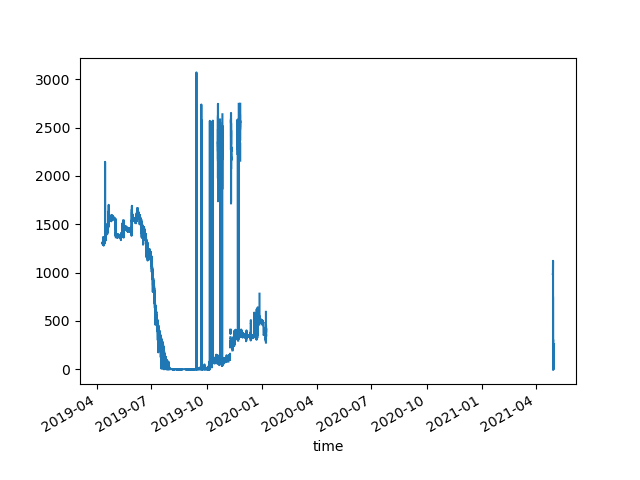

In [15]:
def calibration_snow(df,node_snow):
    ########################################
    # Snow depth calibration
    # Extract dates defining a hydrological year (sept. - sept)
    date_snow=node_snow['year_hydro']

    # Compute median value and assign to new column for output
    df = df.apply(lambda x: np.median(np.array(x)))

    # loop through hydrological year to calibrate snow depth
    for d in range(1,len(date_snow)):

        # Constrain loop to calibrate only period with data
        if date_snow[d] < df.index.min().date(): break
        if date_snow[d-1] > df.index.max().date(): break

        # Compute distance between sensor and reference surface i.e. ice or last summer surface
        height_sensor_to_ice = node_snow['dist_to_sensor'][d-1] + node_snow['depth'][d-1]

        print('---> Process snow depth from {} to {}'.format(format(date_snow[d-1],"%Y-%m-%d"), format(date_snow[d],"%Y-%m-%d")))
        print('     Calibration reference surface to sensor: {} mm on {} '.format(height_sensor_to_ice, format(node_snow['date'][d-1],"%Y-%m-%d")))

        # Calibration of snow depth - Remove negative value i.e. ice melt
        snow_depth = height_sensor_to_ice - df[date_snow[d-1]:date_snow[d]]
        snow_depth[snow_depth<0]= 0

        # Assign in dataframe
        df[date_snow[d-1]:date_snow[d]] = snow_depth
    return df
    ########################################
    
df['mb_distance']=calibration_snow(df['mb_distance'],node['snow'])
df['mb_distance'].plot()

In [8]:
HS

time
2019-04-10 22:00:00    1311.0
2019-04-10 22:00:00    1311.0
2019-04-10 22:10:00    1313.0
2019-04-10 22:20:00    1315.0
2019-04-10 22:30:00    1312.0
                        ...  
2021-04-29 07:00:01       0.0
2021-04-29 07:10:01      42.0
2021-04-29 07:20:01      31.0
2021-04-29 08:40:01    1018.0
2021-04-29 12:20:01    1113.0
Name: mb_distance, Length: 37740, dtype: float64

In [ ]:
########################################
# Extract dates defining a hydrological year (sept. - sept)
date_snow=node['snow']['year_hydro']

# Compute median value and assign to new column for output
df['mb_median'] = df.mb_distance.apply(lambda x: np.median(np.array(x)))

# loop through hydrological year to calibrate snow depth
for d in range(1,len(date_snow)):

    # Constrain loop to calibrate only period with data
    if date_snow[d] < df.index.min().date(): break
    if date_snow[d-1] > df.index.max().date(): break

    # Compute distance between sensor and reference surface i.e. ice or last summer surface
    height_sensor_to_ice = node['snow']['dist_to_sensor'][d-1] + node['snow']['depth'][d-1]

    logging.info('---> Process snow depth from {} to {}'.format(format(date_snow[d-1],"%Y-%m-%d"), format(date_snow[d],"%Y-%m-%d")))
    logging.debug('     Calibration reference surface to sensor: {} mm on {} '.format(height_sensor_to_ice, format(node['snow']['date'][d-1],"%Y-%m-%d")))

    # Calibration of snow depth - Remove negative value i.e. ice melt
    snow_depth = height_sensor_to_ice - df.mb_median[date_snow[d-1]:date_snow[d]]
    snow_depth[snow_depth<0]= 0

    # Assign in dataframe
    df.mb_median[date_snow[d-1]:date_snow[d]] = snow_depth
########################################

In [30]:
########################################
# Snow depth calibration
# Extract dates defining a hydrological year (sept. - sept)
date_snow=node['snow']['year_hydro']

# Compute median value and assign to new column for output
df['mb_distance'] = df.mb_distance.apply(lambda x: np.median(np.array(x)))

# loop through hydrological year to calibrate snow depth
for d in range(1,len(date_snow)):

    # Constrain loop to calibrate only period with data
    if date_snow[d] < df.index.min().date(): break
    if date_snow[d-1] > df.index.max().date(): break

    # Compute distance between sensor and reference surface i.e. ice or last summer surface
    height_sensor_to_ice = node['snow']['dist_to_sensor'][d-1] + node['snow']['depth'][d-1]

    print('---> Process snow depth from {} to {}'.format(format(date_snow[d-1],"%Y-%m-%d"), format(date_snow[d],"%Y-%m-%d")))
    print('     Calibration reference surface to sensor: {} mm on {} '.format(height_sensor_to_ice, format(node['snow']['date'][d-1],"%Y-%m-%d")))

    # Calibration of snow depth - Remove negative value i.e. ice melt
    snow_depth = height_sensor_to_ice - df.mb_distance[date_snow[d-1]:date_snow[d]]
    snow_depth[snow_depth<0]= 0

    # Assign in dataframe
    df.mb_distance[date_snow[d-1]:date_snow[d]] = snow_depth
########################################

[datetime.date(2018, 9, 1),
 datetime.date(2019, 9, 14),
 datetime.date(2020, 9, 1),
 datetime.date(2021, 9, 1),
 datetime.date(2022, 9, 1)]

In [4]:

#df[version['data_sios']]
#node['location']
#node['network']['description']
#'xy({},{},{})'.format(node['location']['easting'],node['location']['northing'],node['location']['elevation'])

# Test dictionary
meteoio_data = [ dict_corres[d][0] for d in version['data_sios'] ]
meteoio_data_corr = [ dict_corres[d][1] for d in version['data_sios'] ]
meteoio_data_scale = [ dict_corres[d][2] for d in version['data_sios'] ]
print(meteoio_data)
print(meteoio_data_corr)
print(meteoio_data_scale)
print(' '.join([     dict_corres[d][0]  for d in version['data_sios'] ]))
print(' '.join([ str(dict_corres[d][1]) for d in version['data_sios'] ]))
print(' '.join([ str(dict_corres[d][2]) for d in version['data_sios'] ]))
'TIMESTAMP {}'.format(' '.join([dict_corres[d][0]  for d in version['data_sios'] ]))
'0 {}'.format(' '.join([str(dict_corres[d][1]) for d in version['data_sios'] ]))
'1 {}'.format(' '.join([ str(dict_corres[d][2]) for d in version['data_sios'] ]))

print(config_ini['Input']['CSV_FIELDS'])
print(config_ini['Input']['CSV_UNITS_OFFSET'])
print(config_ini['Input']['CSV_UNITS_MULTIPLIER'])
#config_ini['Input']['CSV_FIELDS']='TIMESTAMP {}'.format(' '.join(data_meteoio))
config_ini['Input']['CSV_FIELDS']='TIMESTAMP {}'.format(' '.join([dict_corres[d][0]  for d in version['data_sios'] ]))
config_ini['Input']['CSV_UNITS_MULTIPLIER']='1 {}'.format(' '.join([str(dict_corres[d][1]) for d in version['data_sios'] ]))
config_ini['Input']['CSV_UNITS_OFFSET']='0 {}'.format(' '.join([ str(dict_corres[d][2]) for d in version['data_sios'] ]))

['TA', 'RH', 'P', 'HS', 'DW', 'VW', 'TSS']
[1, 0.01, 1, 0.01, 1, 1, 1]
[273.15, 0, 0, 0, 0, 0, 273.15]
TA RH P HS DW VW TSS
1 0.01 1 0.01 1 1 1
273.15 0 0 0 0 0 273.15
TIMESTAMP TA RH P HS DW VW TSS
0 273.15 0 0 0 0 0 273.15
1 1 0.01 1 0.01 1 1 1


---> Process snow depth from 2018-09-01 to 2019-09-14
     Calibration reference surface to sensor: 2650 mm on 2019-04-11 
---> Process snow depth from 2019-09-14 to 2020-09-01
     Calibration reference surface to sensor: 3070 mm on 2020-09-14 
---> Process snow depth from 2020-09-01 to 2021-09-01
     Calibration reference surface to sensor: 1490 mm on 2021-04-29 


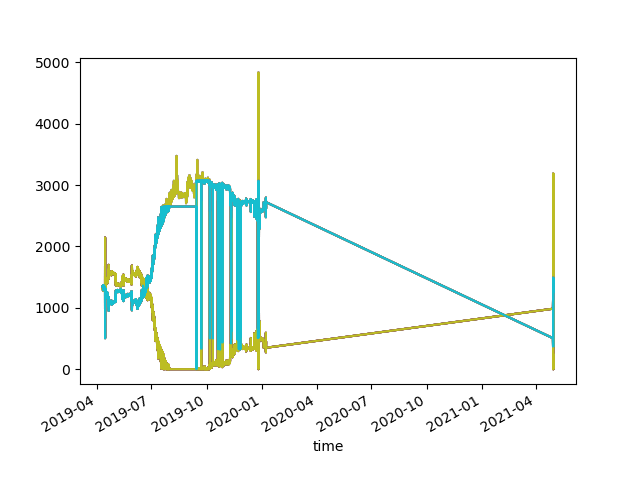

In [74]:
#if len(date_snow)==len(node['snow']['depth']): date_snow.insert(0,df.index[1].date())
#if len(date_snow)==len(node['snow']['depth']): date_snow.insert(0,df.index.min().date())

# Extract dates defining a hydrological year (sept. - sept)
date_snow=node['snow']['year_hydro']

# Compute median value and assign to new column for output
df['mb_median'] = df.mb_distance.apply(lambda x: np.median(np.array(x)))
df['mb_median_corrected'] = df['mb_median']

# loop through hydrological year to calibrate snow depth
for d in range(1,len(date_snow)):
    
    # Constrain loop to calibrate only period with data
    if date_snow[d] < df.index.min().date(): break
    if date_snow[d-1] > df.index.max().date(): break
    
    # Compute distance between sensor and reference surface i.e. ice or last summer surface
    height_sensor_to_ice = node['snow']['dist_to_sensor'][d-1] + node['snow']['depth'][d-1]
    
    print('---> Process snow depth from {} to {}'.format(format(date_snow[d-1],"%Y-%m-%d"), format(date_snow[d],"%Y-%m-%d")))
    print('     Calibration reference surface to sensor: {} mm on {} '.format(height_sensor_to_ice, format(node['snow']['date'][d-1],"%Y-%m-%d")))
    #print(pd.isna(node['snow']['dist_to_sensor'][d-1]))
    
    # Calibration of snow depth - Remove negative value i.e. ice melt
    snow_depth = height_sensor_to_ice - df.mb_median[date_snow[d-1]:date_snow[d]]
    snow_depth[snow_depth<0]= 0
    
    # Assign in dataframe
    df.mb_median_corrected[date_snow[d-1]:date_snow[d]] = snow_depth

df['mb_median'].plot()
df['mb_median_corrected'].plot()

In [20]:
df2=query.query('postgresql',name='sw-001',fields=['mb_distance'],#'tmp_temperature', 
                                     time__gte=datetime.datetime(2019, 4, 11),
                                     time__lte=datetime.datetime(2022, 1, 1),
                                     limit=2000000000000)
print(df2.columns)

df2['mb_median'] = df2.mb_distance.apply(lambda x: np.median(np.array(x)))
plt.plot(df2['mb_median'])
plt.show()

NameError: name 'df2' is not defined